# Example-03: REM (differentiable)

In [1]:
# In this example REM chaos indicator derivative is used for chaos identification

In [2]:
# Import

import numpy

from tqdm import tqdm

import jax
from jax import jit
from jax import vmap
from jax import jacrev
from jax import jacfwd

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward4D
from tohubohu.util import inverse4D

# REM factory

from tohubohu import rem

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", False)

In [4]:
# Set device

device, *_ = jax.devices('gpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set mapping parameters

nux, nuy = 0.168, 0.201
mux, muy = 2*jax.numpy.pi*nux, 2*jax.numpy.pi*nuy
cx, sx, cy, sy = jax.numpy.cos(mux), jax.numpy.sin(mux), jax.numpy.cos(muy), jax.numpy.sin(muy)
mu = 0.0

In [6]:
k = jax.numpy.asarray([cx, sx, cy, sy, mu])
x = jax.numpy.array([0.0, 0.0, 0.0, 0.0])

In [7]:
# Set REM indicator

@jit
def fn(x, *args):
    return jax.numpy.log10(1.0E-16 + rem(2**10, forward4D, inverse4D)(x, *args))

out = fn(x, k)

In [8]:
# Set REM indicator derivative

@jit
def gn(x, *args):
    return jax.numpy.log10(1.0E-16 + jax.numpy.linalg.norm(jacrev(rem(2**10, forward4D, inverse4D))(x, *args)))

out = gn(x, k)

In [9]:
# Set REM indicator second order derivative

@jit
def hn(x, *args):
    return jax.numpy.log10(1.0E-16 + jax.numpy.linalg.norm(jacfwd(jacrev(rem(2**10, forward4D, inverse4D)))(x, *args)))

out = hn(x, k)

In [10]:
# Set initial grid in (qx, qy) plane

n = 1001

qx = jax.numpy.linspace(0.0, 0.6, n)
qy = jax.numpy.linspace(0.0, 0.6, n)
qs = jax.numpy.stack(jax.numpy.meshgrid(qx, qy, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
ps = jax.numpy.full_like(qs, 1.0E-12)
xs = jax.numpy.hstack([qs, ps])
xs = jax.numpy.array_split(xs, n)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.10it/s]


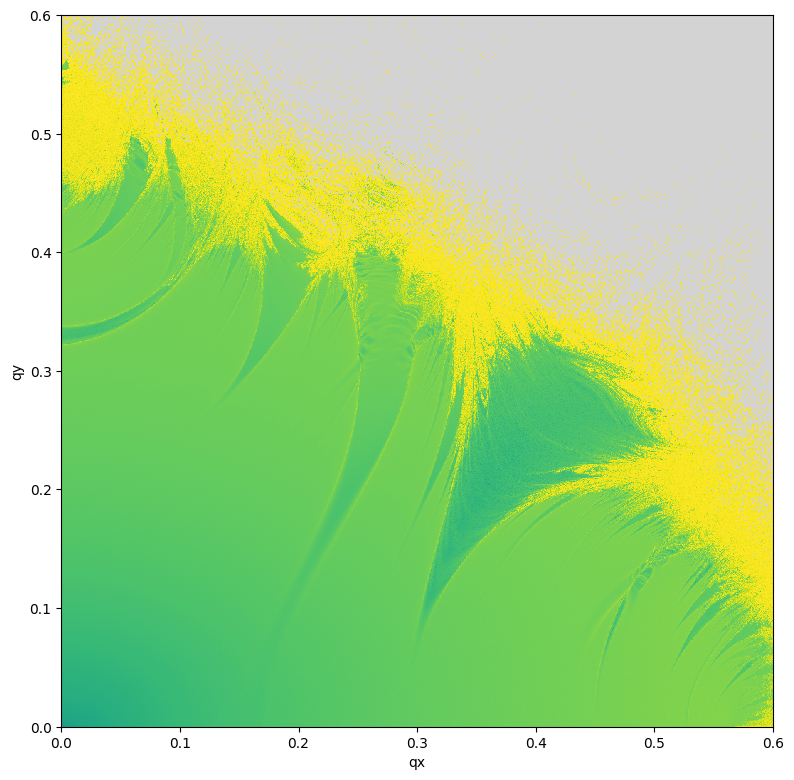

In [11]:
# REM

xb, *xr = xs
fj = jit(vmap(fn, (0, None)))
out = [fj(xb, k)]

for xb in tqdm(xr):
    out.append(fj(xb, k))
out = jax.numpy.concatenate(out)

# Winsorize data

data = numpy.array(out)
data[data < -16.0] = -16.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-16.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.61it/s]


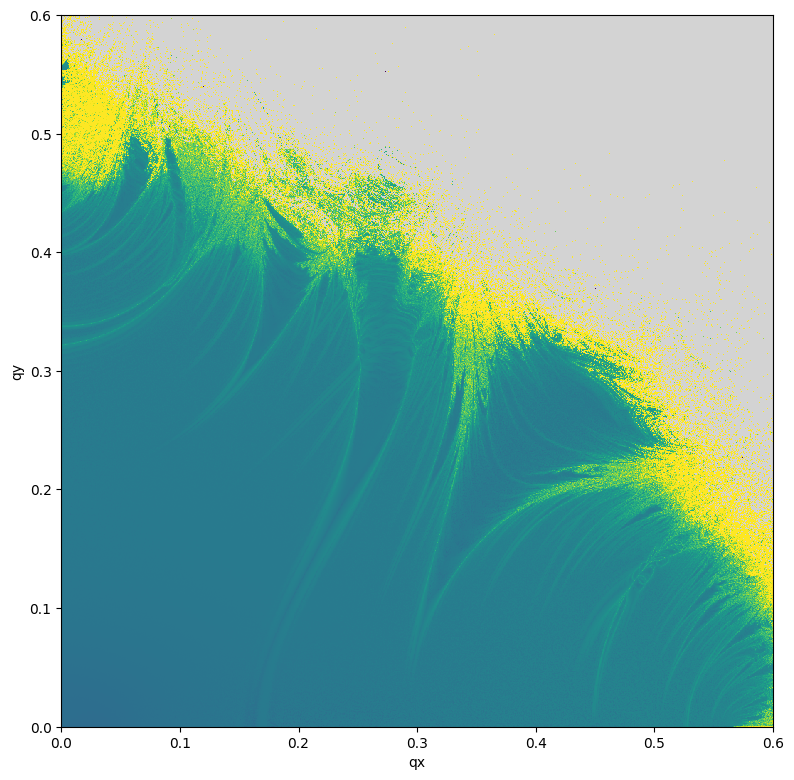

In [12]:
# REM (1st order derivative)

xb, *xr = xs
fj = jit(vmap(gn, (0, None)))
out = [fj(xb, k)]

for xb in tqdm(xr):
    out.append(fj(xb, k))
out = jax.numpy.concatenate(out)

# Winsorize data

data = numpy.array(out)
data[data < -16.0] = -16.0
data[data > 16.0] = 16.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-16.0, vmax=16.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.25it/s]


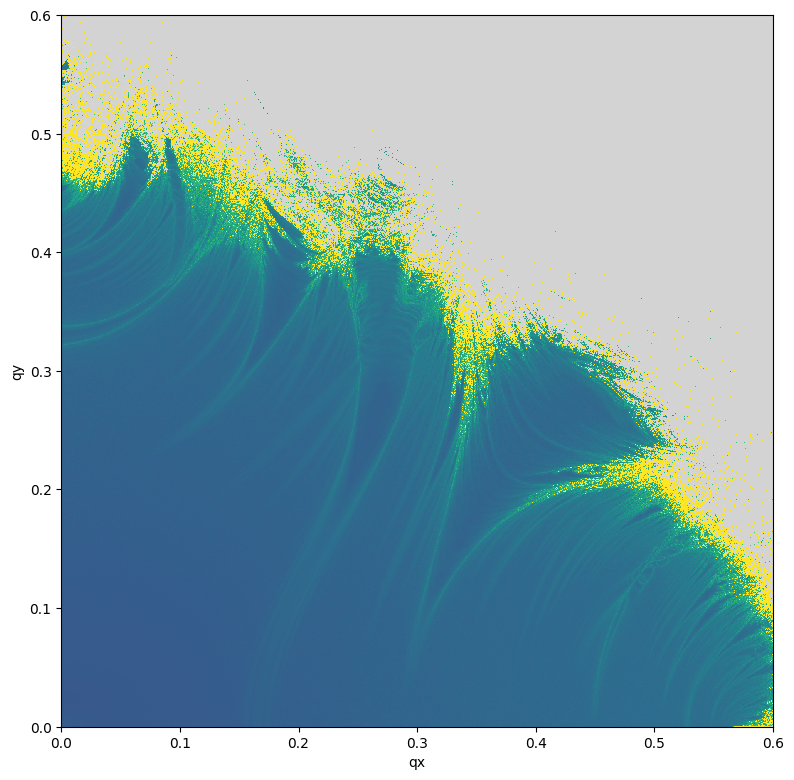

In [13]:
# REM (2nd order derivative)

xb, *xr = xs
fj = jit(vmap(hn, (0, None)))
out = [fj(xb, k)]

for xb in tqdm(xr):
    out.append(fj(xb, k))
out = jax.numpy.concatenate(out)

# Winsorize data

data = numpy.array(out)
data[data < -16.0] = -16.0
data[data > 32.0] = 32.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-16.0, vmax=32.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()